In [1]:
!nvidia-smi

Fri May 17 06:07:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    19W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#!pip install imgaug

import numpy as np
import matplotlib.pyplot as plt

from imgaug import augmenters as iaa
from imgaug import parameters as iap

import random

from sklearn.model_selection import train_test_split

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda

#!pip install livelossplot
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [0]:
X= np.load('X.npy')
y= np.load('y.npy')

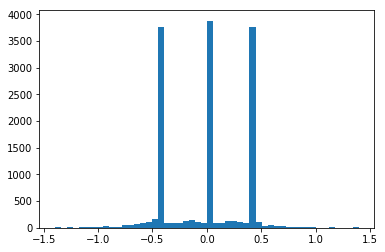

In [4]:
plt.hist(y,50);

In [0]:
#definujemy funkcję która robi lustrzane odbicie zdjęcia, rozmazuje, zmienia kolory, przesuwamy i uzupełniamy losowo
def augment (img, steering_angle):
  #Flip
  if random.random() > 0.5:
    img = img[:, ::-1, :]
    steering_angle = -steering_angle
  #blure
  blurer = iaa.GaussianBlur(iap.Uniform(0.1, 2.0))
  img = blurer.augment_image(img)
  #shuffle
  sh = iaa.ChannelShuffle(p=0.5)
  img = sh.augment_image(img)
  #Fog
  fog = iaa.Fog()
  img = fog.augment_image(img)
  #translate
  tx = random.randint(-20,20)
  translater = iaa.Affine(translate_px = {"x":tx}, mode= 'edge')
  img = translater.augment_image(img)
  steering_angle += tx*0.025
  
  return img, steering_angle

0.0


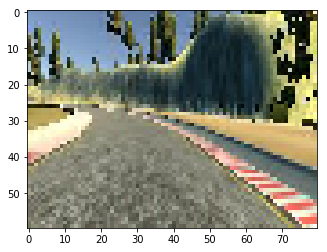

0.225


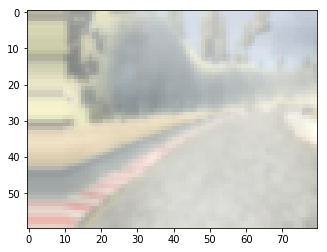

In [36]:
#sprawdzamy ją
plt.imshow(X[0])
print(y[0])
plt.show()

img, angle = augment(X[0], y[0])
plt.imshow(img)
print(angle)
plt.show()

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42 )

In [7]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)

(11095, 60, 80, 3) (11095,)
(2774, 60, 80, 3) (2774,)


In [8]:
Xgen = []
ygen = []

for i in range(X_train.shape[0]):
  img,angle = augment(X[i], y[i])
  Xgen.append(img)
  ygen.append(angle)
  
Xgen = np.array(Xgen)
ygen = np.array(ygen)

print (Xgen.shape, ygen.shape)

(11095, 60, 80, 3) (11095,)


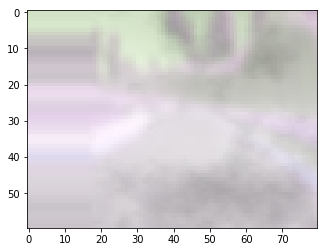

In [11]:
plt.imshow(Xgen[0]);

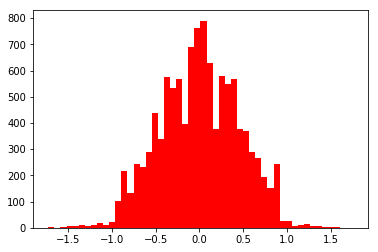

In [12]:
#plt.hist(y_train, 50, facecolor='green');
plt.hist(ygen, 50, facecolor='red');

In [48]:
def myModel(input_shape):
  model = Sequential([
      Lambda(lambda x: (x-128.0)/255.0, input_shape=input_shape, name='normalize'),
      Conv2D(64, (3, 3), activation='relu'),
      # MaxPooling2D(pool_size=(2,2)),
      Conv2D(32, (3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(16, (3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(8, (3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(rate=0.5),
      Flatten(),
      Dense(512, activation='relu'),
      Dropout(rate=0.3),
      Dense(512, activation='relu'),
      Dropout(rate=0.3),
      Dense(16, activation='relu'),
      Dense(1),
  ])
  return model
model = myModel(X[0].shape)
model.summary()
model.compile('adam', 'mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 26, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 18, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 11, 16, 8)         1160      
__________

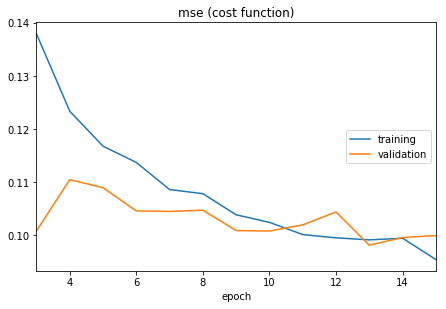

mse (cost function):
training   (min:    0.095, max:    0.191, cur:    0.095)
validation (min:    0.098, max:    0.202, cur:    0.100)


In [49]:
batch_size = 512
epochs = 15

model.fit(Xgen, ygen,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_val, y_val),
         callbacks=[PlotLossesKeras()]          )

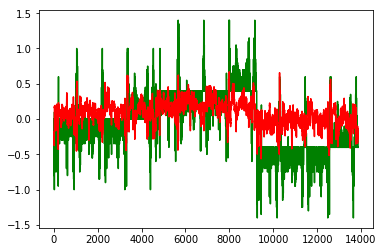

In [51]:
ypred = model.predict(X)
plt.plot(y,'g', ypred, 'r')
plt.show()

In [0]:
model.save('mymodel.h5')

In [53]:
!pip install autokeras

     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 26.6MB 63.2MB/s 
     |████████████████████████████████| 582.5MB 24kB/s 
     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 17.3MB 13.7MB/s 
     |████████████████████████████████| 5.4MB 53.8MB/s 
     |████████████████████████████████| 51kB 25.7MB/s 
     |████████████████████████████████| 3.3MB 51.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/be/a7/37/de16bfa1fbe42e7f5821c13719179ec511633fc772871e9a32
Successfully built autokeras
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.3
    Uninstalling numpy-1.16.3:
      Successfully uninstalled numpy-1.16.3
  Found existing installation: scipy 1.2.1
    Uninstalling scipy-1.2.1:

In [17]:
# podmiana wersji torch dla autokeras
!pip uninstall torch torchvision -y
!pip3 install https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision==0.2.1

Uninstalling torch-1.1.0:
  Successfully uninstalled torch-1.1.0
Uninstalling torchvision-0.2.1:
  Successfully uninstalled torchvision-0.2.1
     |████████████████████████████████| 67.1MB 1.2MB/s 
ERROR: fastai 1.0.52 requires torchvision, which is not installed.
ERROR: autokeras 0.4.0 requires torchvision==0.2.1, which is not installed.


  Using cached https://files.pythonhosted.org/packages/ca/0d/f00b2885711e08bd71242ebe7b96561e6f6d01fdb4b9dcf4d37e2e13c5e1/torchvision-0.2.1-py2.py3-none-any.whl


In [9]:
# automatyczne trenowanie modelu przez autokeras
import autokeras as ak

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [10]:
model_ak = ak.ImageRegressor(verbose=True)
model_ak.fit(Xgen, ygen, time_limit=30*60)

Saving Directory: /tmp/autokeras_U4YBAT
Preprocessing the images.
Preprocessing finished.

Initializing search.
Initialization finished.


+----------------------------------------------+
|               Training model 0               |
+----------------------------------------------+
                                                                              
No loss decrease after 5 epochs.


Saving model.
+--------------------------------------------------------------------------+
|        Model ID        |          Loss          |      Metric Value      |
+--------------------------------------------------------------------------+
|           0            |   0.8115882128477097   |  0.20286788096968994   |
+--------------------------------------------------------------------------+


+----------------------------------------------+
|               Training model 1               |
+----------------------------------------------+
Epoch-1, Current Metric - 0:  12%|███▌              

In [12]:
score = model_ak.evaluate(X_val, y_val)
print(score)

0.12824599562309902


In [0]:
ypred = model_ak.predict(X)

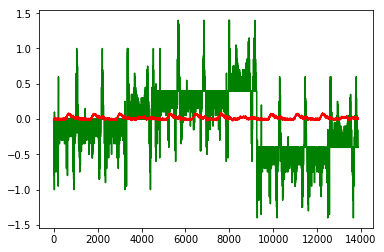

In [14]:
plt.plot(y, 'g', ypred, 'r')
plt.show()

In [0]:
#model_ak.export_keras_model('autokeras.h5')
model_ak.export_autokeras_model('autokeras.pkl')

In [0]:
from autokeras.utils import pickle_from_file
model = pickle_from_file('autokeras.pkl')

In [0]:
yp = model.predict(X_val)